In [1]:
import torch
from torch import nn
import torchvision.models as models
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.preprocessing import LabelEncoder
from PIL import Image
from tqdm import tqdm
import torch
from torch import nn 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
classes = os.listdir("train")

In [4]:
class ImageDataset(Dataset):
    def __init__(self, transform):
        super().__init__()
        
        self.image_dict = {}
        self.transform = transform
        encoder = LabelEncoder()
        self.classes = encoder.fit_transform(classes)
        
        for class_image, class_number in zip(classes, self.classes):
            path = os.path.join("train", class_image)
            path_iterate = os.listdir(os.path.join("train", class_image))
            images = []

            for path_it in path_iterate:
                image = os.path.join(path, path_it)
                images.append(image)


            self.image_dict[class_number] = images
    
    def __len__(self):
        return len(self.image_dict)

    
    def __getitem__(self, index):
        key = list(self.image_dict.keys())[index]
        
        image = self.transform(Image.open(self.image_dict[key][np.random.randint(0, len(self.image_dict[key]))]))
        
        return key, image

In [5]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

In [6]:
image_dataset = ImageDataset(transform)

In [7]:
image = image_dataset.__getitem__(0)[1]

In [8]:
image = image.permute(1,2,0)

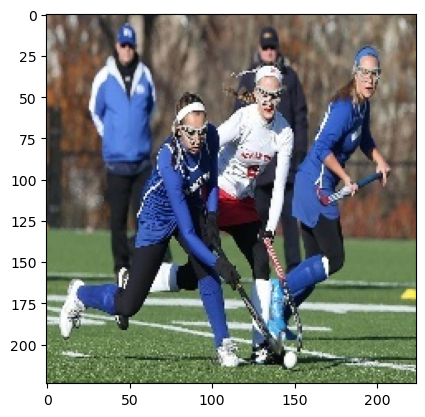

In [9]:
plt.imshow(image)
plt.show()

In [10]:
dataloader = DataLoader(image_dataset, batch_size=8, drop_last=True)

In [11]:
classs, image = next(iter(dataloader))
image.shape

torch.Size([8, 3, 224, 224])

In [12]:
encoder = LabelEncoder()
encoder.fit_transform(classes)

array([26, 12,  9, 81, 97, 22, 52, 95, 18, 90, 55, 84, 56, 33, 25, 67,  6,
       38,  1, 98, 66, 63, 83, 37, 51, 69, 96, 85,  3, 80, 62, 39, 11, 23,
       86, 24, 91, 44, 75, 89, 65, 35, 17, 29, 27, 79, 36, 31, 48, 49, 87,
       73, 21, 77, 68, 42,  4, 10, 72,  7, 34, 43, 45, 19, 13, 41, 32, 74,
       58, 88,  8, 20, 16, 53, 64, 50, 40, 15, 93, 14, 59, 60,  0, 92,  2,
        5, 28, 70, 54, 71, 82, 61, 99, 46, 94, 78, 47, 76, 57, 30])

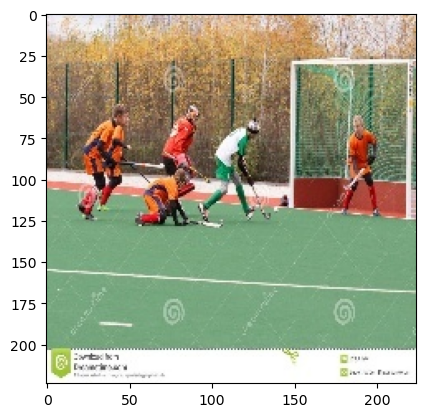

['field hockey']


In [13]:
plt.imshow(np.array(image[0].permute(1,2,0)))
plt.show()
print(encoder.inverse_transform([classs[0]]))

In [14]:
class Conv_block(nn.Module):
    def __init__(self, in_channels, out_channels, num_layers):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.layers = nn.Sequential()
        
        for i in range(num_layers):
            if i == num_layers-1 and self.out_channels != 512:
                self.layers.add_module(f"conv{i+1}", nn.Conv2d(in_channels, out_channels * 2, kernel_size=3, padding=1))
            else:
                self.layers.add_module(f"conv{i+1}", nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
                
            self.layers.add_module(f"relu{i+1}",nn.ReLU())
        self.layers.add_module(f"maxpool", nn.MaxPool2d(kernel_size=(2,2), stride=1))
    
    def forward(self, x):
        x = self.layers(x)
        return x

In [15]:
class VGG_19(nn.Module):
    def __init__(self):
        super().__init__()
        
        layer_numbers = [2, 2, 4, 4, 4]
        layer_channels = [64, 128, 256, 512, 512]
        
        self.module_list = nn.ModuleList()
        
        for number, channels in zip(layer_numbers, layer_channels):
            self.module_list.append(Conv_block(channels, channels, number))
        
        self.adaptive_avg_pool = nn.AdaptiveAvgPool2d((7,7))
        
        self.final_layers = nn.Sequential(
            nn.Linear(25088, 4096),
            nn.ReLU(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, 1000),
            nn.ReLU(),
            nn.Linear(1000, 100),
            nn.Softmax(dim=0)
        )
        
        
    def forward(self, x):
        for layer in self.module_list:
            x = layer(x)
        x = self.adaptive_avg_pool(x)
        x = x.view(-1)
        x = self.final_layers(x)
        
        return x

In [16]:
vgg_mine = VGG_19()

In [17]:
image = torch.randn((3,224,224))
first_layer = nn.Conv2d(3,64,kernel_size=3,padding=1)
result_image = first_layer(image)
result_image.shape

torch.Size([64, 224, 224])

In [18]:
res = vgg_mine(result_image)
res.shape

torch.Size([100])

In [19]:
label, image = next(iter(dataloader))



In [20]:
import torch.nn as nn

class CustomModel(nn.Module):
    def __init__(self, num_classes=100):
        super(CustomModel, self).__init__()
        
        self.fc = nn.Linear(4096, num_classes)

    def forward(self, x):
        x = self.fc(x)
        return x  


model = CustomModel(num_classes=100)

data = torch.randn(1, 4096)

logits = model(data)

class_probabilities = torch.softmax(logits, dim=1)


In [21]:
torch.argmax(class_probabilities).item()

63

In [22]:
class_probabilities

tensor([[0.0081, 0.0029, 0.0082, 0.0109, 0.0072, 0.0070, 0.0054, 0.0081, 0.0109,
         0.0117, 0.0095, 0.0123, 0.0029, 0.0103, 0.0072, 0.0060, 0.0082, 0.0075,
         0.0091, 0.0042, 0.0066, 0.0162, 0.0056, 0.0113, 0.0085, 0.0063, 0.0245,
         0.0019, 0.0133, 0.0040, 0.0184, 0.0046, 0.0110, 0.0145, 0.0047, 0.0202,
         0.0088, 0.0141, 0.0097, 0.0072, 0.0108, 0.0146, 0.0229, 0.0067, 0.0125,
         0.0138, 0.0069, 0.0205, 0.0057, 0.0108, 0.0176, 0.0139, 0.0038, 0.0078,
         0.0063, 0.0042, 0.0288, 0.0088, 0.0116, 0.0038, 0.0082, 0.0172, 0.0054,
         0.0523, 0.0091, 0.0092, 0.0045, 0.0124, 0.0058, 0.0091, 0.0055, 0.0123,
         0.0046, 0.0069, 0.0092, 0.0111, 0.0066, 0.0089, 0.0087, 0.0077, 0.0052,
         0.0108, 0.0095, 0.0084, 0.0025, 0.0036, 0.0109, 0.0210, 0.0039, 0.0093,
         0.0067, 0.0073, 0.0093, 0.0085, 0.0037, 0.0095, 0.0182, 0.0090, 0.0235,
         0.0035]], grad_fn=<SoftmaxBackward0>)

In [23]:
output = torch.zeros((100,100))
label = torch.zeros((100,100))

In [24]:
loss_fn = nn.BCEWithLogitsLoss()

In [25]:
loss_fn(output, label)

tensor(0.6931)

In [26]:
output[0][0] = 1

In [27]:
loss_fn(output, label)

tensor(0.6932)

In [28]:
output

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [29]:
vgg_pretrained = models.vgg19(pretrained=True)

/usr/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [42]:
num_classes = 100
new_classifier = nn.Sequential(
    nn.Linear(4096, 1024),   # Adjust input and output dimensions as needed
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, num_classes),
    nn.Softmax(dim=-1)
)

In [43]:
vgg_pretrained.classifier[6] = new_classifier

In [44]:
vgg_pretrained.to(device);

In [45]:
vgg_pretrained(image.to(device)).shape

torch.Size([8, 100])

In [46]:
learning_rate = 0.1
optimizer = torch.optim.Adam(vgg_pretrained.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss().to(device)

In [47]:
epochs = 100

In [50]:
def train():
    count = 0
    vgg_pretrained.train()
    for epoch in range(1, epochs):
        for labels, images in tqdm(dataloader):
            labels, images = labels.to(device), images.to(device)
            #labels = labels.float()
            
            optimizer.zero_grad()
            
            model_output = vgg_pretrained(images)
            
            loss = loss_fn(model_output, labels)

            loss.backward()
        
            optimizer.step()
            
        if epoch % 1 == 0:
            print(f"{loss.item()}")
            #print(model_output)
            #print(labels)

In [51]:
train()

100%|█████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.71it/s]


4.622207164764404


100%|█████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.76it/s]


4.622207164764404


100%|█████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.75it/s]


4.622207164764404


 92%|████████████████████████████████████████████████▌    | 11/12 [00:03<00:00,  3.43it/s]


KeyboardInterrupt: 